## Lab Assignment Seven: Convolutional Neural Networks

#### Saahil Deshpande, Jeremy Holcombe, Ata Khiabani, Daniel Perez

   Much of modern e-commerce is driven by the use of photos. Modern e-commerce platforms present elegantly captured photographs of their products to generate demand for those products, or at least to simplify the users' efforts in identifying the products in which they are interested. This interaction, however, is overwhelmingly one-sided. We cannot simply project the image we have in our mind of a particular product into the search bar of our favorite store website. While we humans are able to effortlessly extract information about a product once an image is presented to us, we are generally confined to using written language to _describe_ the image we have in mind and hope the search algorithm will select the right products.

   While we are probably a few years away from connecting our mind's eye to the internet, much of the friction associated with searching for products on the web today could be minimized with more sophisticated search algorithms. The ability to input a detailed description of an image into a search bar and be presented with an accurate array of candidates would be a welcome enhancement to the current e-commerce experience.

   In this lab, we explore a data set representing one potential use case of the aforementioned facility. The data set consists of 70,000 labeled images of fashion items, drawn from the German fashion-oriented e-commerce platform, Zalando. The images represent ten different articles of clothing: t-shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. The data set was originally created as a replacement for the famous computer vision benchmarking data set, MNIST, which consists of handwritten digits. As a result, the images are downscaled to a 28 by 28 pixel representation to enable faster computations and, by extension, more flexibility in implementing a range of machine learning algorithms for the purpose of comparison.

   The lower quality of the images makes it more difficult to train an algorithm that could accurately translate a detailed description of a product (e.g., _brown overcoat with three pockets and a narrow zipper_) into matching images of recommended products, as we envisioned above. Rather, the data set presents more of a _proof of concept_ opportunity, enabling us to craft an algorithm that is highly accurate at classifying images of products as the _broad category_ of products they represent and could ultimately be _extended_ to work with higher resolution images down the road.
One possible extension might involve creating a set of filters for different features that may appear on products to assist in the identification of images, rather than simply matching keywords with manually added metadata. The classification model could then be extended to parse the words included in the search query and apply these labeled filters to identifying images of products that contain these elements. Using the example from before, filters could be created for pockets and zippers, which would then identify only coats with such pockets and zippers.

   Even without extending the algorithm or creating a higher resolution data set, a model trained on this data set could provide significant efficiency gains for companies that _aggregate_ fashion products from other retailers and present images of those products along with hyperlinks to those other companies. While many retailers will provide product information with their APIs or in the DOM, this is not a guarantee. The ability to efficiently and accurately classify and label images of products from other retailers would save the company resources and provide an enhanced search experience for the user.
Naturally, if the *ultimate* goal is to provide users of an e-commerce website the ability to describe a product, _in fine detail_, and be served up matching products, then the accuracy of an algorithm intended to classify images with _coarse detail_ should be quite high. Machine learning researchers were able to achieve classification accuracy of 99.7% using convolutional neural networks on the original MNIST data set. While those images were also rendered in 28x28 grayscale (as are these images), the classes (the numbers 0-9) are a fair bit more distinct than those of this data set (i.e., t-shirts, shirts, and coats all have the same general form). Therefore, we would not necessarily expect an algorithm, no matter how finely tuned, to achieve the same level of accuracy on this data set. Instead, we would lower our expectations to 90%-97% in terms of both classification accuracy and precision, which we will discuss in greater detail later (NOTE: Some individuals have already achieved >96% accuracy on this data set). From a practical perspective, it is important that this accuracy be achieved for two reasons: (1) as we mentioned before, the true use case comes from classifying images in much greater detail, thus requiring _at least_ a highly accurate _broad category_ classifier; (2) modern consumers have fairly low tolerance for inaccurate search facilities (just ask Yahoo).

   An alternative method would be for e-commerce companies to add metadata in minute detail for every product, a laborious task that is not scalable and must be performed for every product that enters its inventory. Rather, creating a smaller set of filters for common elements of products and using a classifier to identify products that contain these elements would be much faster and more cost efficient over time. Even with the intermediate goal of classifying broad categories of fashion images that could be achieved with this data set, an automatic classification of images scraped from websites of other retailers would save resources that would otherwise be spent dealing with the often distinct layouts of the DOM or API.

Citation: Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747

In [38]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import expit
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_l_bfgs_b

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

%matplotlib inline

This function, suggested by the dataset creators, loads, unzips and flattens the image to `NumPy` 1-dimensional arrays. We will read the pixels of the images in as 8-bit unsigned integers, which range from 0 to 255 and represent pixel intensity on a grayscale.

In [39]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
    
    print(labels_path)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

We will split the data set into two sets: a training set and a test set. The training set will consist of 60,000 instances, while the test set will contain the remaining 10,000 instances. Since our data set is fairly large (70,000 instances), the reduction of size of the training set should have almost no effect on the accuracy of the classifier. 

Furthermore, no dependence structure exists within our data. If we were working with time series data, we would not want to randomly select observations since the value of one observation is dependent on the values of the observations that precede it. Randomly selecting observations for training and test sets would destroy this dependence structure that is integral to predicting the future. We do not have this issue with our data.

The ~85%/15% split we employ here is a decent tradeoff between lower computation time for training the data and ensuring there is sufficiently low variance of the trained model since we are still using most of the information from the data set to train the model.

In [72]:
# Read in feature matrix (images) and target labels (y) for train and test
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

# Specify the height and width of images in pixels
h, w = 28, 28

data/fashion/train-labels-idx1-ubyte.gz
data/fashion/t10k-labels-idx1-ubyte.gz


Let's get a better understanding of the data we're working with.

In [41]:
# Explore the dimensions of the dataset
print("There are {} images in the training set, each with {} features (i.e., total pixels)."
      .format(X_train.shape[0], X_train.shape[1]))

There are 60000 images in the training set, each with 784 features (i.e., total pixels).


This is what a single image looks like in terms of its pixel values, as the images are 28x28 pixels and there are only 784, it is implied that the images are meant to be rendered in a monochromatic scale.

In [42]:
first_image = pd.DataFrame(np.reshape(X_train[0], (h, w)))
first_image

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,4,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,54,0,0,0,1,3,4,0,0,3
5,0,0,0,0,0,0,0,0,0,0,...,144,123,23,0,0,0,0,12,10,0
6,0,0,0,0,0,0,0,0,0,0,...,107,156,161,109,64,23,77,130,72,15
7,0,0,0,0,0,0,0,0,0,0,...,216,163,127,121,122,146,141,88,172,66
8,0,0,0,0,0,0,0,0,0,1,...,223,223,215,213,164,127,123,196,229,0
9,0,0,0,0,0,0,0,0,0,0,...,235,227,224,222,224,221,223,245,173,0


Here's that same image rendered in grayscale, mapping the pixel intensity values shown above to a spectrum of grayscale from black (0) to white (255).

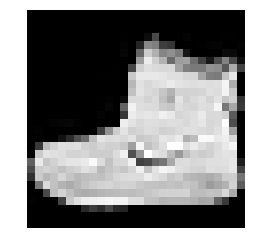

In [43]:
# Plot pixel values in grayscale
plt.imshow(first_image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Let's now view several of our images with their associated labels. Right now, the labels are represented by integers, so we will first map the integers to label values in a dictionary, then vectorize it so we can use it with `NumPy` arrays.

In [44]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 
              'Dress', 'Coat', 'Sandal',
              'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [73]:
# Convert labels to human-readable form
def y_to_labels(y):
    y_labels = {0: "T-shirt/top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle boot"
               }
    return(y_labels[y])
y_to_labels = np.vectorize(y_to_labels)

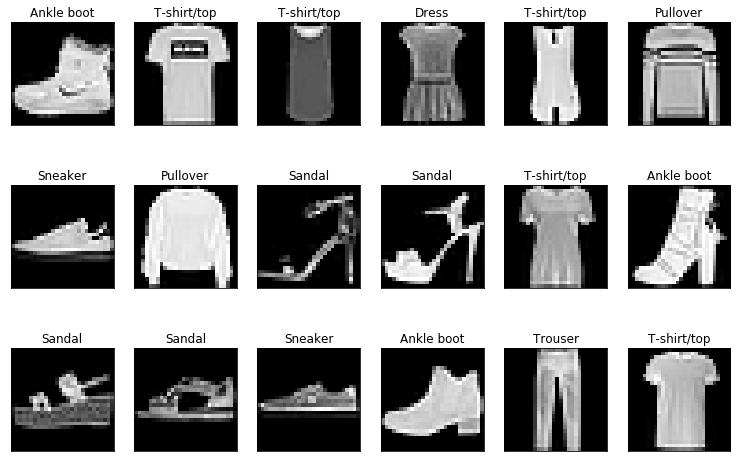

In [46]:
# Source: Eric Larson, Dimensionality Reduction & Images lecture
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_to_labels(y_train), h, w) # defaults to showing a 3 by 6 subset of the images

#### Image Preprocessing

In order to improve the rate of convergence for our optimization algorithms, we will want to normalize the pixel values so that they range from [-1, 1] instead of [0, 255].

In [47]:
print("The pixel values currently range from:", np.min(X_train), np.max(X_train))

The pixel values currently range from: 0 255


In [74]:
# Normalize the pixel values
X_train = ((X_train / 255.) - 0.5) * 2
X_test = ((X_test / 255.) - 0.5) * 2

print("New range:", np.min(X_train), np.max(X_train))

New range: -1.0 1.0


The resulting data set should exactly mirror the original, except that the specific data values are constrained between -1 and 1. This will help with model convergence, but does not change the structure of the data.

## Evaluation Metrics

#### Evaluation Measures

When training classifiers, it is important to keep in mind the metric(s) used to evaluate their performance. The most basic of these metrics, **classification accuracy**, is defined as the number of correctly classified instances divided by the total number of instances. While this metric seems intuitive, it is not necessarily always the correct one to use. The **accuracy paradox** tells us that some models with high accuracy can have zero predictive power. This effect comes into play whenever there exists a relatively high class imbalance or whenever the cost of a False Positive is not the same as that of a False Negative. For instance, if the minority class represents just 1% of the instances, then simply predicting the majority class for every instance will yield 99% classification accuracy. The accuracy rate, in this case, seems high, but does not provide any information about the predictive power of the classifier.

For this reason, other metrics are often better suited for these types of situations. For instance, **recall** evaluates how well the classifier is able to predict the minority class or classes, computing the ratio of true positives to the sum of true positives and false negatives. The **precision** evaluates the classifier's ability to avoid classifying an instance as positive when it is actually negative, computing the ratio of true positives to the sum of true positives and false positives. Other metrics, such as the **F1** score, try to combine some of the simple metrics into one number that can generalize the performance of the classifier. A general rule of thumb is that **classification accuracy** is appropriate whenever the cost of a false positive is equal to the cost of a false negative, and when the classes are relatively balanced.

If we are using the classifier to serve up accurate search results to our users, we are more interested in avoiding false positives (i.e., **precision**) than we are in accurately selecting _all_ possible results of a particular article of clothing (i.e., **recall**). If customers search for _sweaters_ and receive results for _ankle boots_ in return, they will immediately lose confidence in the website's search facility and the user experience will suffer. If, in contrast, customers receive a list of 1,000 _sweaters_ out of 10,000 possible sweaters, they will still have a large offering of sweaters from which to choose and will be unaware that not all of the images that were truly of sweaters were returned in the search results.

For this reason, we will use the **precision** measure to tune our models and evaluate their performance.

#### Model Selection Methods

In order to ensure that we avoid overfitting our model to our training data, we will employ **k-fold cross validation** to tune the hyperparameters of our models and select the model with the best performance, as measured by the **precision score**.

K-fold cross validation allows us to evaluate the performance of numerous models using only the training data. The training data will be separated into `k` partitions and the model will be trained on `k-1` partitions, then evaluated on the held-out partition. This process will be repeated `k` times, at which point the performance measure will be averaged across all of the model fittings. This procedure should enable us to strike an optimal balance between reducing bias while still allowing the model to generalize to unseen data.

In cases where the training set exhibits class imbalance, it is important to stratify the cross validation scheme such that each class is equally represented across each of the partitions. This helps to reduce the variance in prediction performance across the partitions and provides a more accurate measure of predictive power of the model.

We can determine whether we need to utilize **stratified k-fold cross validation** by observing the distribution of instances across the 10 classes in our data set.

[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


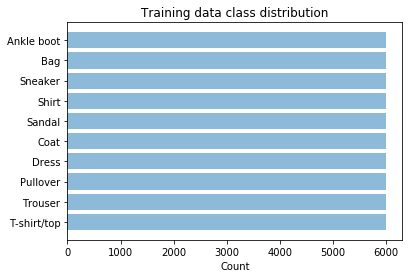

In [49]:
# Count the number of instances in each class
y_pos = np.arange(len(classes))
counts = np.bincount(y_train)
print(counts)

# Plot the results in a bar chart
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, classes)
plt.xlabel('Count')
plt.title('Training data class distribution')
plt.show()

As we can see from the plot above, each class is equally represented in the training set. Thus, we have no reason to stratify our cross validation scheme and will instead use **k-fold cross validation** for tuning our models. We will ultimately determine how well our model performs by making predictions on a held-out test set. The test set will strictly be used for evaluating the final model so as to avoid overfitting to the test set.

## Modeling

We will train our classifier using a variety of convolutional neural network (CNN) architectures. We will then evaluate the performance of each architecture, as measured by **precision**, and select the optimal architecture to compare against a basic two-layer multilayer perceptron (MLP). Finally, we will attempt to improve the generalization performance of our CNN architecture using data expansion.

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.0.8'

In [75]:
NUM_CLASSES = 10
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


#### Multilayer Perceptron (MLP)

We will use a basic two-layer MLP architecture as a benchmark against which we will compare the performance of our CNN.

In [52]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 2 layer keras MLP (default sklearn implementation for MLPClassifier)
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=50, 
        shuffle=True, verbose=0)

CPU times: user 17min 4s, sys: 1min 26s, total: 18min 30s
Wall time: 7min 19s


#### Convolutional Neural Network (CNN)

We will use GridSearchCV to determine our best possible model based on 4-fold cross-validated precision. We can then use this model to visualize the differences in precision for different model architectures.

First, we must create a function to compile a convolutional neural network architecture using Keras. We can then use this function as part of `sklearn's` `GridSearchCV` module to tune our hyperparameters of choice.

In [53]:
def cnn_model(X_train=X_train, y_train=y_train, h=28, w=28, num_filter_layers=[16], kernel_size=(3,3), 
              pool_size=(2,2), strides=2, hidden_units=100, activation_inter='relu', 
              activation_final='softmax', loss='categorical_crossentropy', optimizer='nadam', 
              metrics=['accuracy'], drop_prob=(0,0)):
    """Fit a convolutional neural network."""
    
    NUM_CLASSES = np.unique(y_train).shape[0]
    y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
    
    # Create a sequential neural network
    model = Sequential()
    model.add(Reshape((1, h, w), input_shape=(1, h*w)))
   
    # Add convolution and pooling layers
    num_filt_layers = num_filter_layers
    for num_filters in num_filter_layers:
        model.add(Conv2D(filters=num_filters, 
                        kernel_size=kernel_size, 
                        padding='same'))
        model.add(Activation(activation_inter))
        model.add(MaxPooling2D(pool_size=pool_size, strides=strides, 
                              data_format="channels_first"))
        model.add(Dropout(drop_prob[0]))
        
    # add one layer on flattened output
    model.add(Flatten())
    model.add(Dense(hidden_units))
    model.add(Activation(activation_inter))
    model.add(Dropout(drop_prob[1]))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation(activation_final))
    
    # Let's train the model 
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    return model

In [54]:
%%time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, precision_score

# Set up possible values of parameters to optimize over
p_grid = {'num_filter_layers': [[16], [24, 48]],
          'hidden_units': [100, 1000],
          'drop_prob': [(0,0), (0.2,0), (0,0.5), (0.2,0.5)]}

# Perform grid search on CNN model
cnn = KerasClassifier(build_fn=cnn_model, batch_size=32, epochs=15)

# Choose cross-validation technique
cv = KFold(n_splits=4, shuffle=True)

# Make precision scorer
precision_scorer = make_scorer(precision_score, average='micro')

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=cnn, param_grid=p_grid, cv=cv, 
                   scoring=precision_scorer, verbose=1)
clf.fit(np.expand_dims(X_train, axis=1), y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Epoch 1/15
45000/45000 [==============================] - 9s - loss: 0.5221 - acc: 0.8112     
Epoch 2/15
45000/45000 [==============================] - 8s - loss: 0.3862 - acc: 0.8578     
Epoch 3/15
45000/45000 [==============================] - 8s - loss: 0.3540 - acc: 0.8688     
Epoch 4/15
45000/45000 [==============================] - 8s - loss: 0.3329 - acc: 0.8773     
Epoch 5/15
45000/45000 [==============================] - 8s - loss: 0.3161 - acc: 0.8819     
Epoch 6/15
45000/45000 [==============================] - 8s - loss: 0.3045 - acc: 0.8873     
Epoch 7/15
45000/45000 [==============================] - 8s - loss: 0.2931 - acc: 0.8922     
Epoch 8/15
45000/45000 [==============================] - 8s - loss: 0.2874 - acc: 0.8925     
Epoch 9/15
45000/45000 [==============================] - 8s - loss: 0.2775 - acc: 0.8965     
Epoch 10/15
45000/45000 [==============================] - 8s - loss: 0.2715 - acc: 

45000/45000 [==============================] - 12s - loss: 0.4851 - acc: 0.8243    
Epoch 2/15
45000/45000 [==============================] - 12s - loss: 0.3674 - acc: 0.8649    
Epoch 3/15
45000/45000 [==============================] - 11s - loss: 0.3285 - acc: 0.8771    
Epoch 4/15
45000/45000 [==============================] - 9s - loss: 0.3057 - acc: 0.8856     
Epoch 5/15
45000/45000 [==============================] - 9s - loss: 0.2865 - acc: 0.8932     
Epoch 6/15
45000/45000 [==============================] - 10s - loss: 0.2669 - acc: 0.8998    
Epoch 7/15
45000/45000 [==============================] - 9s - loss: 0.2500 - acc: 0.9058     
Epoch 8/15
45000/45000 [==============================] - 10s - loss: 0.2365 - acc: 0.9113    
Epoch 9/15
45000/45000 [==============================] - 11s - loss: 0.2221 - acc: 0.9169    
Epoch 10/15
45000/45000 [==============================] - 9s - loss: 0.2118 - acc: 0.9198     
Epoch 11/15
45000/45000 [==============================] - 1

45000/45000 [==============================] - 16s - loss: 0.3584 - acc: 0.8655    
Epoch 15/15
45000/45000 [==============================] - 18s - loss: 0.6350 - acc: 0.7671    
Epoch 2/15
45000/45000 [==============================] - 16s - loss: 0.4746 - acc: 0.8248    
Epoch 3/15
45000/45000 [==============================] - 16s - loss: 0.4349 - acc: 0.8409    
Epoch 4/15
45000/45000 [==============================] - 16s - loss: 0.4157 - acc: 0.8461    
Epoch 5/15
45000/45000 [==============================] - 16s - loss: 0.4049 - acc: 0.8493    
Epoch 6/15
45000/45000 [==============================] - 16s - loss: 0.3942 - acc: 0.8521    
Epoch 7/15
45000/45000 [==============================] - 16s - loss: 0.3850 - acc: 0.8579    
Epoch 8/15
45000/45000 [==============================] - 16s - loss: 0.3767 - acc: 0.8579    
Epoch 9/15
45000/45000 [==============================] - 16s - loss: 0.3752 - acc: 0.8607    
Epoch 10/15
45000/45000 [==============================] - 1

45000/45000 [==============================] - 9s - loss: 0.3656 - acc: 0.8631     
Epoch 15/15
45000/45000 [==============================] - 11s - loss: 0.6654 - acc: 0.7638    
Epoch 2/15
45000/45000 [==============================] - 9s - loss: 0.4820 - acc: 0.8294     
Epoch 3/15
45000/45000 [==============================] - 9s - loss: 0.4503 - acc: 0.8393     
Epoch 4/15
45000/45000 [==============================] - 9s - loss: 0.4300 - acc: 0.8447     
Epoch 5/15
45000/45000 [==============================] - 9s - loss: 0.4203 - acc: 0.8481     
Epoch 6/15
45000/45000 [==============================] - 9s - loss: 0.4076 - acc: 0.8510     
Epoch 7/15
45000/45000 [==============================] - 9s - loss: 0.4029 - acc: 0.8519     
Epoch 8/15
45000/45000 [==============================] - 9s - loss: 0.3950 - acc: 0.8562     
Epoch 9/15
45000/45000 [==============================] - 9s - loss: 0.3924 - acc: 0.8571     
Epoch 10/15
45000/45000 [==============================] - 9

45000/45000 [==============================] - 13s - loss: 0.3053 - acc: 0.8880    
Epoch 13/15
45000/45000 [==============================] - 13s - loss: 0.2960 - acc: 0.8892    
Epoch 14/15
45000/45000 [==============================] - 11s - loss: 0.2969 - acc: 0.8920    
Epoch 15/15
45000/45000 [==============================] - 19s - loss: 0.5300 - acc: 0.8060    
Epoch 2/15
45000/45000 [==============================] - 17s - loss: 0.3867 - acc: 0.8581    
Epoch 3/15
45000/45000 [==============================] - 17s - loss: 0.3598 - acc: 0.8680    
Epoch 4/15
45000/45000 [==============================] - 17s - loss: 0.3376 - acc: 0.8747    
Epoch 5/15
45000/45000 [==============================] - 17s - loss: 0.3262 - acc: 0.8808    
Epoch 6/15
45000/45000 [==============================] - 18s - loss: 0.3138 - acc: 0.8833    
Epoch 7/15
45000/45000 [==============================] - 17s - loss: 0.3074 - acc: 0.8854    
Epoch 8/15
45000/45000 [==============================] - 

45000/45000 [==============================] - 17s - loss: 0.4462 - acc: 0.8359    
Epoch 13/15
45000/45000 [==============================] - 17s - loss: 0.4411 - acc: 0.8386    
Epoch 14/15
45000/45000 [==============================] - 17s - loss: 0.4407 - acc: 0.8394    
Epoch 15/15
45000/45000 [==============================] - 19s - loss: 0.7511 - acc: 0.7265    
Epoch 2/15
45000/45000 [==============================] - 17s - loss: 0.5593 - acc: 0.8002    
Epoch 3/15
45000/45000 [==============================] - 17s - loss: 0.5160 - acc: 0.8125    
Epoch 4/15
45000/45000 [==============================] - 17s - loss: 0.4969 - acc: 0.8207    
Epoch 5/15
45000/45000 [==============================] - 17s - loss: 0.4867 - acc: 0.8234    
Epoch 6/15
45000/45000 [==============================] - 17s - loss: 0.4740 - acc: 0.8282    
Epoch 7/15
45000/45000 [==============================] - 17s - loss: 0.4650 - acc: 0.8304    
Epoch 8/15
45000/45000 [==============================] - 

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed: 235.7min finished


Epoch 1/15
60000/60000 [==============================] - 24s - loss: 0.4822 - acc: 0.8242    
Epoch 2/15
60000/60000 [==============================] - 22s - loss: 0.3563 - acc: 0.8686    
Epoch 3/15
60000/60000 [==============================] - 22s - loss: 0.3252 - acc: 0.8790    
Epoch 4/15
60000/60000 [==============================] - 22s - loss: 0.3060 - acc: 0.8865    
Epoch 5/15
60000/60000 [==============================] - 22s - loss: 0.2921 - acc: 0.8901    
Epoch 6/15
60000/60000 [==============================] - 22s - loss: 0.2804 - acc: 0.8941    
Epoch 7/15
60000/60000 [==============================] - 22s - loss: 0.2698 - acc: 0.8996    
Epoch 8/15
60000/60000 [==============================] - 22s - loss: 0.2631 - acc: 0.9013    
Epoch 9/15
60000/60000 [==============================] - 22s - loss: 0.2566 - acc: 0.9043    
Epoch 10/15
60000/60000 [==============================] - 22s - loss: 0.2474 - acc: 0.9070    
Epoch 11/15
60000/60000 [========================

In [55]:
# Hyperparameter settings for best model
print("These are the parameter values of our best model:\n", clf.best_params_)
print("With these parameters, the precision is: ", clf.best_score_)

These are the parameter values of our best model:
 {'drop_prob': (0, 0), 'hidden_units': 100, 'num_filter_layers': [24, 48]}
With these parameters, the precision is:  0.88545


### Comparing CNN architectures

Even though we have found out the best set of parameters by applying a grid search, we would like to show the performance of two different Convolutional Neural Network architectures.


In [76]:
%%time
# Best CNN model
cnn_best = cnn_model(num_filter_layers=[24,48], kernel_size=(5,5), hidden_units=1000, 
                     optimizer='nadam', drop_prob=(0,0))

# we need to expand the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn_best_cb = cnn_best.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
             batch_size=32, epochs=30, 
             shuffle=True, verbose=0)

CPU times: user 43min 13s, sys: 1min 45s, total: 44min 58s
Wall time: 13min 7s


In [78]:
%%time
# Different architecture
cnn_diff = cnn_model(num_filter_layers=[24,24], kernel_size=(5,5), hidden_units=500, 
                     optimizer='nadam', drop_prob=(0.5, 0.2))

# we need to expand the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn_diff_cb = cnn_diff.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
                           batch_size=32, epochs=30, 
                           shuffle=True, verbose=0)

CPU times: user 34min 3s, sys: 1min 30s, total: 35min 33s
Wall time: 11min 46s


In [86]:
%%time
# Different architecture
cnn_diff2 = cnn_model(num_filter_layers=[48,24], kernel_size=(5,5), hidden_units=1000, 
                     optimizer='nadam', drop_prob=(0.2, 0.1))

# we need to expand the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn_diff2_cb = cnn_diff2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
                           batch_size=32, epochs=30, 
                           shuffle=True, verbose=0)

CPU times: user 54min 54s, sys: 1min 56s, total: 56min 51s
Wall time: 17min 9s


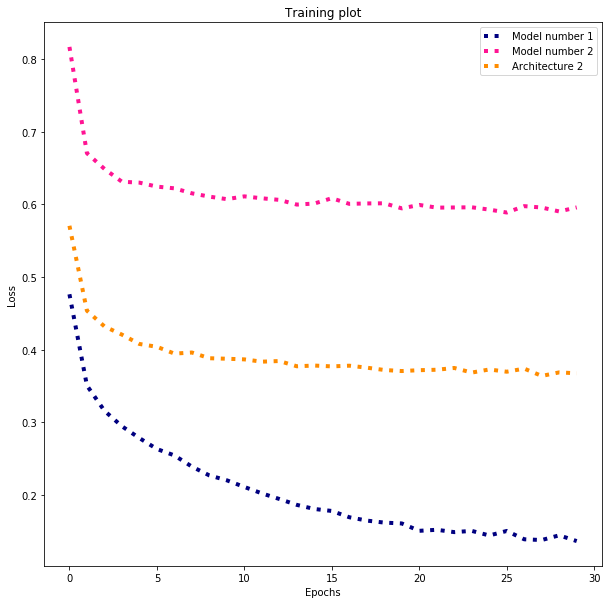

In [87]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline

cmap = cm.gist_ncar

# Plot all ROC curves
plt.figure(figsize=(10, 10))
plt.plot(cnn_best_cb.history['loss'],
         label='Model number 1',
         color='navy', linestyle=':', linewidth=4)

plt.plot(cnn_diff_cb.history['loss'],
         label='Model number 2',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(cnn_diff2_cb.history['loss'],
         label='Architecture 2',
         color='darkorange', linestyle=':', linewidth=4)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training plot')
plt.legend(loc="upper right")
plt.show()
        

### Comparing CNN to MLP

We will select the architecture that produced the highest precision from the various architectures we tested. We will train the model on the full training set and evaluate its performance against the holdout test set, which has not to this point been utilized.

We will then compare the CNN's performance against that of the basic multi-layer perceptron.

Now we will compare the convolutional neural network's performance to that of a standard multi-layer perceptron. We will evaluate the performance with two different metrics:
- Precision
- Area Under the Curve for the Receiver Operating Characteristic

In [57]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        prec_cnn = mt.precision_score(y_test, yhat_cnn, average='micro')
        plt.subplot(1, 2, 1)
        cm = mt.confusion_matrix(y_test, yhat_cnn)
        cm = cm/np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(prec_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        prec_mlp = mt.precision_score(y_test, yhat_mlp, average='micro')
        plt.subplot(1, 2, 2)
        cm = mt.confusion_matrix(y_test, yhat_mlp)
        cm = cm/np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('MLP: '+str(prec_mlp))

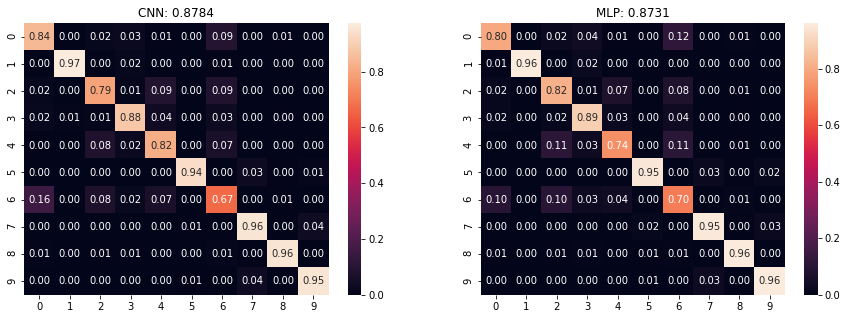

In [58]:
compare_mlp_cnn(cnn_best, mlp, X_test, y_test)

The next metric will help us determine the area under the Receiver Operating Characteristic curve (AUC of ROC), which provides insight into the trade-off between a model's specificity and sensitivity.

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def roc_auc_analysis(test, score, plot=False, plot_n=10, figsize=(10,10)):
    n_classes = score.shape[1]
    y_score = score
    y_test = label_binarize(test, classes=np.arange(n_classes))

    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if (plot):
        cmap = cm.gist_ncar
        norm = Normalize(vmin=0, vmax=n_classes)

        # Plot all ROC curves
        plt.figure(figsize=figsize)
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i in range(plot_n):
            color = cmap(norm(i))
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    return(roc_auc)

Let's plot the ROC curve and compute the AUC for each of the 10 classes for the best model:

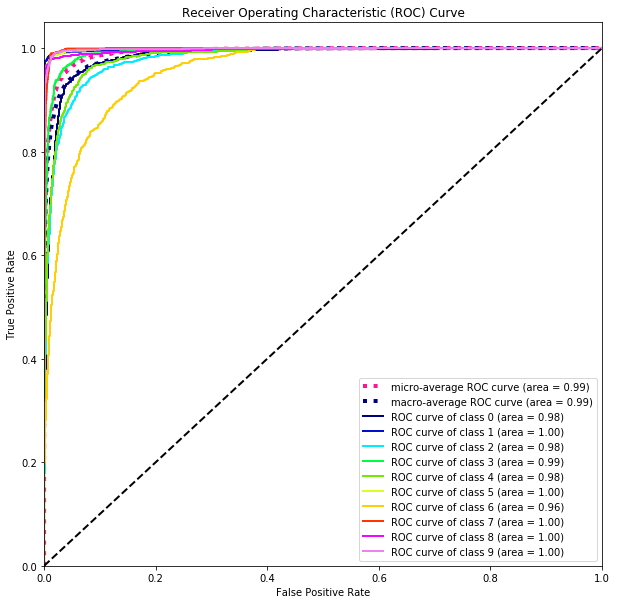

The macro AUC is: 0.988717194444


In [60]:
cnn_auc = roc_auc_analysis(y_test, cnn_best.predict(np.expand_dims(X_test, axis=1)), 
                           plot=True, plot_n=10)
print('The macro AUC is: %s'%(cnn_auc['macro']))

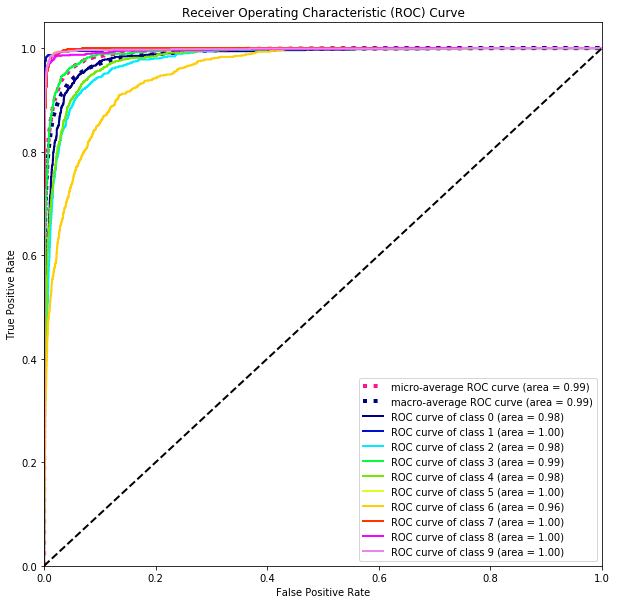

The macro AUC is: 0.987910033333


In [61]:
mlp_auc = roc_auc_analysis(y_test, mlp.predict(X_test), plot=True, plot_n=10)
print('The macro AUC is: %s'%(mlp_auc['macro']))

To calculate if the difference in AUC is statistically significant, 95% Confidence intervals are built to represent the distribution of the AUC.

In [80]:
cnn_auc = []
mlp_auc = []

b = 10
n_classes = 10

cv = KFold(n_splits=10)

for train, test in cv.split(X_train):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()        
    
    curr_cnn_model = cnn_best.fit(np.expand_dims(X_train, axis=1)[train], y_train_ohe[train],
                              batch_size=32, epochs=15, shuffle=True, verbose=0)
    
    curr_mlp_model = mlp.fit(X_train[train], y_train_ohe[train], 
                             batch_size=32, epochs=50, 
                             shuffle=True, verbose=0)
        
    cnn_auc.append(roc_auc_analysis(y_train[test], cnn_best.predict(np.expand_dims(X_train[test,:], axis=1)), 
                           plot=False, plot_n=10))
    mlp_auc.append(roc_auc_analysis(y_train[test], mlp.predict(X_train[test,:]), plot=False, plot_n=10))

In [81]:
mean_cnn_auc = np.mean([roc['macro'] for roc in cnn_auc])
mean_mlp_auc = np.mean([roc['macro'] for roc in mlp_auc])

se_cnn_auc = np.std([roc['macro'] for roc in cnn_auc])
se_mlp_auc = np.std([roc['macro'] for roc in mlp_auc])

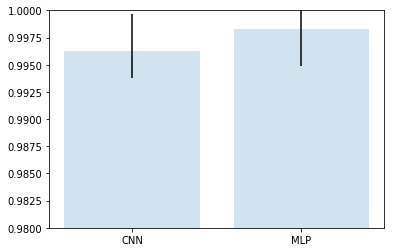

In [82]:
from scipy import stats
means = [mean_cnn_auc, mean_mlp_auc]
t_crit = stats.t.ppf(q=(0.025,0.975), df=b-1)

# the confidence intervals you provided
ci = [(mean_cnn_auc-se_cnn_auc*t_crit, mean_cnn_auc+se_cnn_auc*t_crit),
      (mean_mlp_auc-se_mlp_auc*t_crit, mean_mlp_auc+se_mlp_auc*t_crit)]

# get the range of the confidence interval
y_r = [means[i] - ci[i][1] for i in range(len(ci))]
plt.bar(range(len(means)), means, yerr=y_r, alpha=0.2, align='center')
plt.xticks(range(len(means)), ['CNN', 'MLP'])
plt.ylim( (0.98, 1) )
plt.show()

The barplot above provides some evidence that there might be a possibility that the AUCs of the MLP and CNN are different. However, the confidence intervals overlap each other and we need to perform further analysis

We could do a two sample independent t-test to figure out if the difference in AUC is significant:

In [83]:
stats.ttest_ind([roc['macro'] for roc in cnn_auc], [roc['macro'] for roc in mlp_auc], equal_var = False)

Ttest_indResult(statistic=-3.1327828767815569, pvalue=0.0061705774903682651)

The p-value is 0.00617 which is less than 0.05. This is a significant result to conclude that there is enough evidence that the AUC for CNN is different from the AUC for MLP. We, however, should not guide ourselves by precision alone. Other factors such as model complexity and other metrics such as precision and even the shape of the ROC should be taken into account to choose a final model.

#### Data Expansion

The idea with data expansion, is to help the neural network generalize better. This is done during the training phase by feeding the neural network slightly transformed versions of the original data set. This transformations ensure that the network does not see the same image every time, forcing it to learn features that are generalizable among classes and not for given instances. 

Another reason to use data expansion is that in our data set, images have been preprocessed. All of the clothing articles have been centered, scaled and aligned. This homogeneity is less likely to happen on a production environment and the trained model could quickly lose its validity. By applying transformations such as rotation and vertial/horizontal shift, we artificially replicate the proper environment under our model is likely to be working.

In [62]:
# Let's start by fixing the sizes
X_train = np.expand_dims(X_train.reshape((-1,h,w)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,h,w)), axis=3)

# the image data has been resized to (samples,image_rows,image_cols,image_channels)

NUM_CLASSES = np.unique(y_train).shape[0]

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [63]:
from keras.preprocessing.image import ImageDataGenerator

In [64]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

In [65]:
def cnn_model_ex(X_train=X_train, y_train=y_train, h=28, w=28, num_filter_layers=[64], kernel_size=(3,3), 
              pool_size=(2,2), strides=2, activation_inter='relu', hidden_units=128,
              activation_final='softmax', loss='categorical_crossentropy', optimizer='nadam', 
              metrics=['accuracy'], drop_prob=(0,0)):

    cnn = Sequential()

    cnn.add(Conv2D(filters=32,
                    input_shape = (h,w,1),
                    kernel_size=kernel_size, 
                    padding='same', 
                    activation=activation_inter)) # more compact syntax
    
    num_filt_layers = num_filter_layers
    for num_filters in num_filter_layers:
        cnn.add(Conv2D(filters=num_filters,
                        kernel_size=kernel_size, 
                        padding='same', 
                        activation=activation_inter)) # more compact syntax
        cnn.add(MaxPooling2D(pool_size=pool_size, data_format="channels_last"))
    

    # add one layer on flattened output
    cnn.add(Dropout(drop_prob[0])) # add some dropout for regularization after conv layers
    cnn.add(Flatten())
    cnn.add(Dense(hidden_units, activation=activation_inter))
    cnn.add(Dropout(drop_prob[1])) # add some dropout for regularization, again!
    cnn.add(Dense(NUM_CLASSES, activation=activation_final))

    # Let's train the model 
    cnn.compile(loss=loss, # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer=optimizer, # 'adadelta' 'rmsprop'
                  metrics=metrics)

    return cnn

In [66]:
# the flow method yields batches of images indefinitely, with the given transformations
cnn = cnn_model_ex(num_filter_layers=[24,48], kernel_size=(5,5), hidden_units=1000, 
                     optimizer='nadam', drop_prob=(0,0))
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=15, verbose=1,
                       validation_data=(X_test,y_test_ohe)
                 )

Epoch 1/15
468/468 [==============================] - 396s - loss: 0.5461 - acc: 0.7973 - val_loss: 0.3309 - val_acc: 0.8801
Epoch 2/15
468/468 [==============================] - 396s - loss: 0.3473 - acc: 0.8705 - val_loss: 0.2929 - val_acc: 0.8919
Epoch 3/15
468/468 [==============================] - 396s - loss: 0.3100 - acc: 0.8852 - val_loss: 0.2987 - val_acc: 0.8928
Epoch 4/15
468/468 [==============================] - 396s - loss: 0.2882 - acc: 0.8930 - val_loss: 0.2611 - val_acc: 0.9057
Epoch 5/15
468/468 [==============================] - 397s - loss: 0.2750 - acc: 0.8983 - val_loss: 0.2419 - val_acc: 0.9117
Epoch 6/15
468/468 [==============================] - 397s - loss: 0.2594 - acc: 0.9023 - val_loss: 0.2330 - val_acc: 0.9131
Epoch 7/15
468/468 [==============================] - 396s - loss: 0.2524 - acc: 0.9057 - val_loss: 0.2467 - val_acc: 0.9099
Epoch 8/15
468/468 [==============================] - 395s - loss: 0.2444 - acc: 0.9093 - val_loss: 0.2465 - val_acc: 0.9135


In [67]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.precision_score(y_test, yhat, average='micro')
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

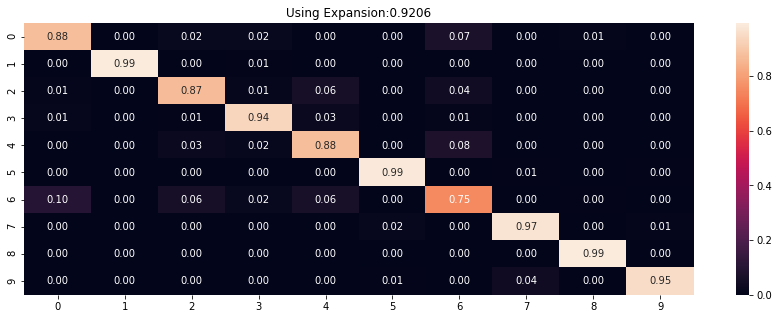

In [68]:
summarize_net(cnn, X_test, y_test, title_text='Using Expansion:')

The results show that data expansion does help the network generalize better as the precision increases noticeably.